In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import emcee, corner, starry

In [2]:
# Import the helper package I wrote for you
import helper

# Setup instructions

This will take ~25 MB and should be done before the lab.

```conda install starry```

OR

```pip install starry==0.3.0```

# Introduction to Exoplanet Science

Some day we are going to find a planet in another solar system that might harbour life, and we're going to want to know everything about that planet: what temperature the planet is, whether there's water in its atmosphere, etc. In the further future, we may even want to know whether there are continents and oceans on an exoplanet, and people are already writing code to model the future observations that will allow us to determine this (e.g. [Farr et al. 2018](https://iopscience.iop.org/article/10.3847/1538-3881/aad775/pdf)).

However, our images look like complete garbage because these systems are so far away. We just see a single, unresolved blob of light that contains all the starlight and the light of the planet. Here is a real Spitzer image for example:

<img src='images/WASP12b_Spitzer_Image.png' width=40%>
<center>Image Credit: Bell et al. 2019</center>

Since we can't directly see exoplanets themselves (or at least not in the vast majority of cases), we instead have to resort to indirect techniques for now (with future advances in techniques like direct imaging potentially allowing us to do this more easily or differently).

# Exoplanet Transits

When a planet passes in front of its host star, we see a dip in brightness as some starlight is blocked. Using this phoenomenon, we can infer the star-planet radius ratio.

<img src='images/640px-Kepler_6b.png' width=40%>
<center>Image Credit: Wikipedia</center>

As you can see, however, transits are normally not flat bottomed. This is due to a phoenomenon known as limb darkening https://en.wikipedia.org/wiki/Limb_darkening. This is caused by stars having a non-uniform surface brightness which makes stars appear dimmer and redder near their edges (called the limb of the star). An image of the Sun is below, showing the effect of limb darkening as well as the transit of Venus in the upper right corner.

<img src='images/720px-2012_Transit_of_Venus_from_SF.jpg' width=20%>
<center>Image Credit: Wikipedia</center>

This effect can be reasonably modelled as a quadratic function of separation from the centre of the star's visible disk of the form:

\begin{equation}
    I(\mu) = I_0[1 - q_1(1 - \mu) - q_2(1-\mu)^2]
\end{equation}

where $\mu = \sqrt{1-x^2}$ and $x$ is the normalized impact parameter ($0 \le x \le 1$).

# Introduction to starry

Thankfully there have been numerous people that have come before us, and we don't need to re-invent the wheel.

Only recently, [Luger et al. 2019](https://arxiv.org/pdf/1810.06559.pdf) wrote a package in python called $\texttt{starry}$ which will do almost everything we need analytically (and therefore very quickly). Much of the introduction to the $\texttt{starry}$ package has been drawn directly from their own tutorial which can be found at https://rodluger.github.io/starry/v0.3.0/tutorials/basics3.html

To make a star object using $\texttt{starry}$ and initialize it's limb-darkening, we do the following:

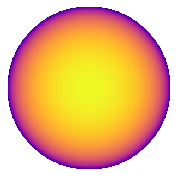

In [3]:
star = starry.kepler.Primary()
star[1] = 0.40 # linear term
star[2] = 0.26 # quadratic term

star.show()

We’ve given the star a quadratically limb-darkened ($\texttt{udeg} = 2$). The aplitude $\texttt{amp}$ controls the overall scaling of the intensity of the object and is therefore equal to its luminosity (in arbitrary units).

To then initialize the planet, we can do the following:

In [4]:
planet = starry.kepler.Secondary(lmax=1)  # (lmax described later)

planet.L = 0   # (described later)
planet.r = 0.1  # radius in stellar radii
planet.a = 5   # orbital semi-major axis in units of the stellar radii.
planet.inc = 90 # orbital inclination (90 degrees is an edge-on orbit)
planet.porb = 1.0  # orbital period in days
planet.prot = 1.0  # rotation period in days (synchronous if prot=porb)
planet.ecc = 0.  # eccentricity
planet.w = 30  # longitude of pericenter in degrees (meaningless for ecc=0)
planet.tref = 0  # time of transit in days

To show the lightcurve of the system, we can then do the following

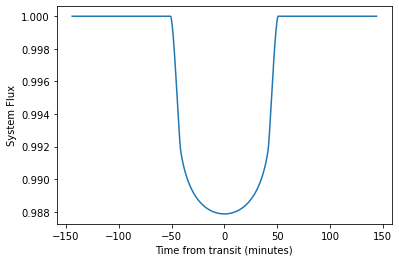

In [5]:
system = starry.kepler.System(star, planet)
time = np.linspace(-0.1, 0.1, 1000)

system.compute(time) # compute the lightcurve which will be stored within system
flux_system = system.lightcurve

plt.plot((time-planet.tref)*24*60, flux_system)
plt.xlabel("Time from transit (minutes)")
plt.ylabel("System Flux")
plt.show()

### Question 1)

Make a new planet that has the same characteristics as my favourite planet WASP-12b whose information can be found at http://exoplanet.eu/catalog/wasp-12_b/. For now, you can still use ```lmax=1``` and ```planet.L=0```. Make sure to set ```planet.prot``` to the same value as ```planet.porb```

The other thing to make note of is that whereas we arbitrarily set the transit time `planet.tref` to zero before for our fake transit, here we have the actual time of the transit from the data base (as a Julian Date). Be sure to put that information in, or some of the later parts of the lab will not work.

Make a plot showing the full transit of WASP-12b with ~30 minutes of flat baseline on either side of the transit (this is what a typical observation of an exoplanet would look like).

In [6]:
# Your code goes here
planet = starry.kepler.Secondary(lmax=1)  # (lmax described later)

planet.L = 0   # (described later)
planet.r = 1.9*0.102763  # radius in stellar radii
planet.a = 0.02344*215.032   # orbital semi-major axis in units of the stellar radii.
planet.inc = 83.37 # orbital inclination (90 degrees is an edge-on orbit)
planet.porb = 1.0914203  # orbital period in days
planet.prot = 1.0914203  # rotation period in days (synchronous if prot=porb)
planet.ecc = 0.  # eccentricity
planet.w = 30  # longitude of pericenter in degrees (meaningless for ecc=0)
planet.tref = 2456176.66826  # time of transit in days

# Exoplanet Eclipses

A very similar phoenomenon occurs on the other side of the orbit when the planet passes behind the star—this is called an secondary eclipse, or just eclipse. This time though, the planet will be fully obscured by the much larger star, and we expect to see a flat bottomed lightcurve. The depth of the eclipse tells us about how bright the planet is compared to the host star, as well as the radius ratio of the two objects (which we can measure using the transit).

To set the luminosity ratio $L_p/L_*$ of the system, you use the syntax ```planet.L = myValue```

### Question 2)

Let's assume we're looking at the eclipse of WASP-12b using the Channel 2 detector of the IRAC instrument on the Spitzer Space Telescope, which has a central wavelength of 4.5 $\mu$m and a bandwidth of 1 $\mu$m.

As a moderately reasonable approximation, we'll assume that the planet and star are blackbodies, allowing us to compute the fluxes of the bodies using [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law). Numerically integrate $B_{\lambda}$ over the channel 2 bandpass for both the planet and the star (nothing fancy here, just the np.sum($B_{\lambda}$\*d$\lambda$) that you're used to doing). Assume a dayside effective temperature of 3000 K [(Bell et al., 2019)](https://arxiv.org/pdf/1906.04742.pdf) and a stellar effective temperature of 6300 K [(Hebb et al., 2009)](https://arxiv.org/pdf/0812.3240.pdf).

Next, compute the power output by each object by multiplying by $(\pi ~\text{steradians})*\text{Radius}^2$. Be careful with your units here! Assume that the planet appears to have a radius of 1.7182 R$_{\rm Jup}$ at 4.5 $\mu$m [(Bell et al., 2019)](https://arxiv.org/pdf/1906.04742.pdf) and keep your literature value for the stellar radius.

Then compute the planet-to-star power ratio of the two objects, and assign it to ```planet.L``` (we'll assume there is no flux coming from the side facing away from the star for now). You should get a value of 0.3917%. Also update your ```planet.r``` for the the radius of the planet as seen at 4.5 $\mu$m, keeping in mind that this is in units of stellar radii.

Finally, plot the eclipse lightcurve (which should take place halfway around the orbit since we set the orbital eccentricity to zero). How does the depth of the eclipse compare to the depth of the transit?

In [7]:
# Your code goes here 
from astropy.modeling.models import BlackBody
from astropy import units as u

band=np.linspace(3.5,5.5,1000)*u.micron
d=band[1]-band[0]

planetbb=BlackBody(temperature=3000*u.K)
stellarbb=BlackBody(temperature=6300*u.K)

B_planet=planetbb(band)
B_star=stellarbb(band)

planetInt=np.sum(B_planet*d)
stellarInt=np.sum(B_star*d)

planet.r=1.7182*0.102763
planetPower=planetInt*((1.7182*0.102763)**2)*np.pi
stellarPower=stellarInt*(1**2)*np.pi
planet.L=planetPower/stellarPower
planet.L=0.003917

print(planet.L)


0.003917


<function matplotlib.pyplot.show(close=None, block=None)>

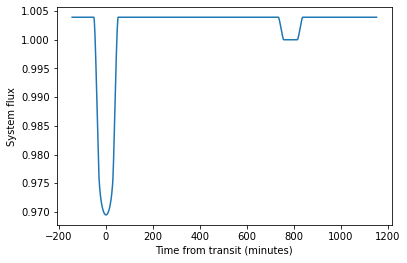

In [8]:
system=starry.kepler.System(star,planet)
time=np.linspace(planet.tref-0.1,planet.tref+0.8,1000)

system.compute(time)

flux_system=system.lightcurve

plt.plot(((time-planet.tref)*24*60),flux_system)
plt.xlabel("Time from transit (minutes)")
plt.ylabel("System flux")
plt.show

# Exoplanet Phasecurves

There are many different ways of modelling the temperature variations on the surface of an exoplanet. For almost all of the planets that current instruments are able to observe, the planets day is equal to its year—this is called synchronous rotation, and is a special case of tidal locking. In this situation, the planet has a hemisphere that is permanently illuminated by its host star (which we call the dayside), and a hemisphere that is in perpetual darkness (which we call the nightside). This strong contrast in irradiation results in a strong temperature contrast between the day and night hemispheres. This strong temperature contrast then leads to rapid winds which transport heat from the dayside toward the nightside. Complicated fluid dynamics simulations suggest that these winds should (for the most part) flow to the east (which is defined as having a spin vector aligned with the orbital spin vector).

A reasonable way to model the temperature of these highly irradiated, synchronously rotating exoplanets is just a simple Fourier series as a function of longitude. Since we are dealing with a spherical surface, we will use spherical harmonics to model the temperature map of the planet.

Above, we set ```lmax=1``` while initializing our ```planet``` object. This corresponds to a 1st order spherical harmonic map. Each term is depicted below:
<img src="images/ylms.png" width=50%>
<center>Image Credit: https://rodluger.github.io/starry/v0.3.0/tutorials/basics1.html</center>

The zeroth order term (l=0,m=0) sets the overall output of the planet, (l=1,m=0) sets the day-to-night contrast, and (l=1,m=1) sets the longitudinal offset of the hottest point on the planet (where positive values are eastward offsets). The term (l=1,m=-1) is generally assumed to be zero and is exceedingly difficult to measure anyways.

We previously set the $\ell=0$ term using ```planet.L```. To set the higher order terms, you use the syntax ```planet[l,m] = myValue```

Let's imagine our observations start at eclipse where we would be seeing the scorching hot dayside of the planet. As the planet orbits around the star, that dayside of the planet stays facing the star and we begin to see parts of the cooler nightside. Then when we get to the time of transit, we will be seeing only the cold nightside of the planet. These variations in the average temperature of the hemisphere facing us results in sinusoidal modulations in the flux coming from the planet with a maximum near eclipse and a minimum near transit. We call these variations phase variations, and we call the observation of the full orbit of the system a phasecurve.

An example image showing the full orbit phasecurve is shown below

<img src="images/phasecurve.jpg" width=70%>
<center>Image Credit: JPL </center>

Going back to WASP-12b, the planet's nightside temperature was found to be 1340 K [(Bell et al., 2019)](https://arxiv.org/pdf/1906.04742.pdf), giving a planet-to-star flux ratio of 0.0743%. The offset in the brightest point in the phasecurve from the centre of eclipse was also found to be 19.1 degrees east. To make our planet model have a nightside flux ratio of 0.0743%, a dayside flux ratio of 0.3917%, and a phase offset of 19.1 degrees east, we'll need to set ```planet[1,0]``` and ```planet[1,1]``` to some non-zero value. This will increase the dayside flux and decrease the nightside flux, so to keep the same eclipse depth we'll also need to renormalize ```planet.L```.

To get us ready for fitting real data soon, we're going to do this by fitting our $\texttt{starry}$ model to the simple sinusoidal model I used in my paper. I'll generate the data that you need to fit below:

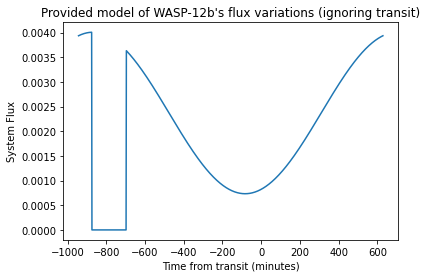

In [9]:
tstart = planet.tref-planet.porb/2-0.1*planet.porb # Start just before eclipse
tend = tstart + planet.porb # End one orbital period later
time = np.linspace(tstart, tend, 1000)

# Taking fitted values from my Bell+2019 paper
phasecurve = 0.003917*(1+0.395*(-1+np.cos(2*np.pi*(time-planet.tref-planet.porb/2.)/planet.porb))
                        -0.136*np.sin(2*np.pi*(time-planet.tref-planet.porb/2.)/planet.porb))

# Set the flux during eclipse to zero
eclDuration = 178./60./24.
inEclipse = np.logical_and(time<planet.tref-planet.porb/2+eclDuration/2, time>planet.tref-planet.porb/2-eclDuration/2)
phasecurve[inEclipse] = 0

plt.plot((time-planet.tref)*24*60, phasecurve)
plt.title('Provided model of WASP-12b\'s flux variations (ignoring transit)')
plt.xlabel("Time from transit (minutes)")
plt.ylabel("System Flux")
plt.show()

### Question #3)

Fit the ```planet``` parameters to the data provided in my array ```phasecurve```. To do this, use the function ```scipy.optimize.minimize```, and make an initial guess of $\theta_0$=[0.004, 0.4, 0.1] for ```planet.L```, ```planet[1,0]```, and ```planet[1,1]``` respectively. The function that you want ```scipy``` to minimize should take in an intial guess $\theta_0$, use that to update the three ```planet``` parameters, recompute the phasecurve by doing ```system.compute(time)```, and then return the mean squared error (MSE) between ```planet.lightcurve``` and my ```phasecurve``` array. You should also set ```method='Nelder-Mead'``` when calling ```scipy.optimize.minimize``` as it will work better for this data than the default method.

Get the best-fit parameters and update your ```planet``` parameters. Make a plot showing that your fitted ```planet.lightcurve``` is pretty close to my ```phasecurve``` array.

(Common pitfall: here we want just the **planet's** contribution light curve, i.e., `planet.lightcurve`. This is different from the light curve of the whole **system**, which we would get using `system.lightcurve`. Put another way, we are trying to model just the brown part of the image above, not the yellow part)

The best-fit parameters are [0.00210574 0.42957389 0.21714104]


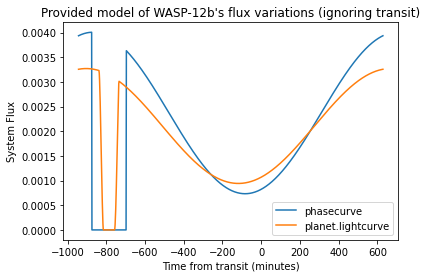

In [10]:
# Your code goes here

import scipy

def mse_theta0 (theta0):
    planet.L = theta0[0]
    planet[1,0] = theta0[1]
    planet[1,1] = theta0[2]
    system.compute(time)
    mse = ((phasecurve - planet.lightcurve)**2).mean()
    return mse

optimize_result = scipy.optimize.minimize(mse_theta0, [0.004, 0.4, 0.1], method='Nelder-Mead')
print("The best-fit parameters are", optimize_result.x)

plt.plot((time-planet.tref)*24*60, phasecurve, label='phasecurve')
plt.plot((time-planet.tref)*24*60, planet.lightcurve, label='planet.lightcurve')
plt.title('Provided model of WASP-12b\'s flux variations (ignoring transit)')
plt.xlabel("Time from transit (minutes)")
plt.ylabel("System Flux")
plt.legend(loc='best')
plt.show()

# Detector Systematics and Decorrelation

Unfortunately, no phasecurve that we collect using Spitzer looks anywhere near that clean. Imperfections in our telescopes and/or detectors cause strong correlated noise in our data—we call this detector systematics.

For the IRAC channel 1 and channel 2 cameras on Spitzer, the dominant source of detector systematics is intra-pixel sensitivity variations. Each individual pixel is a square piece of semiconductor that is made up of indium and antimony. Because we are not able to make these pixels perfectly, we end up with pixels that are more sensitive to incoming photons in the middle of the pixel and less sensitive to photons near the edges of the pixel. There are also gaps between pixels where no light is collected at all.

As Spitzer is a space telescope, it is free-floating and is prone to oscillations in the direction it is pointing because it has nothing it can secure itself to. While this shaking motion is controlled enough for most uses of the telescope, this shaking drifts the starlight around by a signficant fraction of a pixel. This results in fairly rapid fluctuations in brightness that are of a similar strength as our astrophysical signal. For example, here is the raw data showing the raw flux from the system and the position of the star on the detector over time.

<img src='images/raw_WASP12b_lightcurve.png' width=100%>
<center>Image Credit: Bell et al. 2019</center>

While the transit is visible by eye, all other obvious signals are caused by detector systematics. However, all hope is not lost! You can clearly see that there is a very strong and repeatable correlation between the position of the star on the detector and the flux we measure. By trying to model this correlation, we can try to measure the underlying astrophysical signal that we are interested in. This is where things get tough though... Every research group has their own idea of how to best model these detector systematics and firmly believes everybody else does it wrong. The more likely truth, we're all modelling these systematics wrong to an extent and each technique probably has its strengths and weaknesses.

To dip our toes into this fun but challenging world, we are going to code up the simplest possible detector model and try fitting real, previously published Spitzer data!

### Question 4 Setup

First we need to load in the data that we will fit. I've given you the real Spitzer data for the exoplanet CoRoT-2b. I have also written some code that will load in the data for that phasecurve for you.

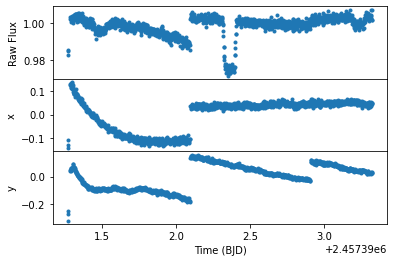

In [11]:
flux, time, x, y = helper.get_data('CoRoT-2b_ch2_datacube_binned.dat')

fig, axs = plt.subplots(3, sharex=True, sharey=False, gridspec_kw={'hspace': 0})
axs[0].plot(time, flux, '.')
axs[1].plot(time, x, '.')
axs[2].plot(time, y, '.')
axs[0].set_ylabel('Raw Flux')
axs[1].set_ylabel('x')
axs[2].set_ylabel('y')
axs[2].set_xlabel('Time (BJD)')
plt.show()

### Question 4a)

Make a new planet variable here (with lmax=1). Initialize it with the values you find at http://exoplanet.eu/catalog/corot-2_b/

In [12]:
# Your code goes here

planet = starry.kepler.Secondary(lmax=1)  # (lmax described later)

planet.L = 0   # (described later)
planet.r = 1.465*0.102763  # radius in stellar radii
planet.a = 0.0281*215.032   # orbital semi-major axis in units of the stellar radii.
planet.inc = 87.84 # orbital inclination (90 degrees is an edge-on orbit)
planet.porb = 1.7429964  # orbital period in days
planet.prot = 1.7429964  # rotation period in days (synchronous if prot=porb)
planet.ecc = 0.  # eccentricity
planet.w = 30  # longitude of pericenter in degrees (meaningless for ecc=0)
planet.tref = 2454706.4041  # time of transit in days

### Question 4b)

Write up a simple function to model the sensitivity of the detector where the sensitivity is a second-order,2-dimensional polynomial as a function of the $x$ and $y$ position of the star. Second order means that the function includes terms up to $x^2$, $y^2$, and all the cross-terms (6 total coefficients). You can write this from scratch or find a scipy/numpy function or some other function that does it for you, but make sure to acknowledge the source of your code if you did not write it yourself.

In [13]:
# Your code goes here

def sensitivity_model (x, y, a, b, c, d, e, f):
    return a * x**2 + b * y**2 + c + d * x * y + e * x + f * y

### Question 4c)

Now write a function that puts all of our work together. The parameters that you are going to be fitting for are the two stellar limb darkening parameters (```star[1]``` and ```star[2]```), the ```planet.r``` parameter (planet-to-star radius ratio), the ```planet.L``` parameter, the ```planet[1,0]``` and ```planet[1,1]``` parameters, and the 6 polynomial coefficients.

Your function should take 5 inputs: the $\theta_0$ guess holding your 12 fitted parameters, the time, the x and y arrays, the ```star``` variable, and the ```planet``` variable. It should:
* Use the $\theta_0$ parameter to update all of the relevant components of ```star``` and ```planet```
* Make a ```system```, i.e., run the line `system = starry.kepler.System(star, planet)`
* Run the function ```system.compute```
* Multiply the light curve ```system.lightcurve``` by the sensitivity model you wrote for the previous part.

In [14]:
# Your code goes here

def flux_theta0 (theta0,time,x,y,star,planet):
    star[1] = theta0[0]
    star[2] = theta0[1]
    planet.r = theta0[2]
    planet.L = theta0[3]
    planet[1,0] = theta0[4]
    planet[1,1] = theta0[5]
    system = starry.kepler.System(star, planet)
    system.compute(time)
    flux_fit = system.lightcurve * sensitivity_model(x, y, theta0[6], theta0[7], theta0[8], theta0[9], theta0[10], theta0[11])
    return flux_fit

### Question 4d)

Now write a log-probability function that evaluates the fit of the model. The function should take all of the same inputs as the function you wrote for Question 4c, but $\theta_0$ will contain one extra parameter—the $\sigma$ parameter describing the white noise in the data; we have to fit for this since we don't know what it should be given our data.

Feel free to look back at your Lab 07 work or the Search and Rescue files if you need to remember how to write one of these functions.

To be a little more explicit here, let's say that we think of the light curve as being stored in a vector $\mathbf{d}$, where the first element of the vector is the light curve at the first time instant, the second element is the light curve at the second time instant etc. If we then assume that the noise in the detector of the instrument is Gaussian, then we have
\begin{equation}
p({\boldsymbol \theta} | \mathbf{d}) \propto p({\boldsymbol \theta})p({\mathbf{d} | \boldsymbol \theta}) = p({\boldsymbol \theta})\prod_i \frac{1}{\sqrt{ 2 \pi \sigma^2}} \exp \bigg{\{} -\frac{[d_i - d_i^\textrm{model}( {\boldsymbol \theta})]^2}{2 \sigma^2}\bigg{\}}
\end{equation}

Be careful here! Very often one can ignore the $1/\sqrt{ 2 \pi \sigma^2}$ piece when doing Bayesian inference because it's just a proportionality constant. But here, we are fitting for $\sigma$ because we don't know its value (i.e., our data didn't come with error bars). So this term can't be ignored.

Note also that here we are asking for the log posterior $\ln(p({\boldsymbol \theta} | \mathbf{d}) \propto p({\boldsymbol \theta})$ because recall that `emcee` asks for the log posterior, not the posterior itself.

As for a prior, you should:
1. constrain the planet's radius to be positive and smaller 1
2. constrain the planet's luminosity to be positive and smaller than 1
3. constrain the planet's surface brightness to be positive everywhere (negative flux makes no sense). This can be checked using ```planet.is_physical()``` <u>after</u> having updated the planet's parameters.

In [15]:
# Your code goes here

from scipy.stats import norm

def log_likelihood (theta0,time,x,y,star,planet):
    star[1] = theta0[0]
    star[2] = theta0[1]
    planet.r = theta0[2]
    planet.L = theta0[3]
    planet[1,0] = theta0[4]
    planet[1,1] = theta0[5]
    system = starry.kepler.System(star, planet)
    system.compute(time)
    flux_fit = system.lightcurve * sensitivity_model(x, y, theta0[6], theta0[7], theta0[8], theta0[9], theta0[10], theta0[11])
    prob_array = norm(flux,theta0[12]).pdf(flux_fit)
    log_like = np.sum(np.log(prob_array))
    return log_like

def log_prior(theta0,planet):
    if theta0[2] < 1 and theta0[2] > 0:
        planet.r = theta0[2]
    else:
        return -np.inf # log(0) = -inf
    if theta0[3] < 1 and theta0[3] > 0:
        planet.L = theta0[3]
    else:
        return -np.inf # log(0) = -inf
    planet[1,0] = theta0[4]
    planet[1,1] = theta0[5]
    if not (theta0[12] > 0):
        return -np.inf # log(0) = -inf
    if not planet.is_physical():
        return -np.inf # log(0) = -inf
    return 0.0 # the constant doesn't matter since MCMCs only care about *ratios* of probabilities

def log_post(theta0,time,x,y,star,planet):
    lp = log_prior(theta0,planet)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta0,time,x,y,star,planet)

### Question 4e)

Make an initial guess $\theta_0$, setting:
* rp to ~0.1, your L to ~1e-3
* your ```planet[1,0]``` parameter to ~0.4
* your ```planet[1,1]``` parameter to ~0
* your q1 and q2 terms to ~0.1 (scroll all the way back up to the equation about limb darkening to remind yourself what this is!)
* your constant polynomial term to 1
* your other polynomial terms to ~0.01, and
* your white noise parameter to ~1e-3.
These guesses will get us in the right ballpark, but aren't great guesses.

Plot your initial guess against the data to make sure it looks vaguely reasonable.

Make a dense Gaussian ball around these initial guesses so that each MCMC walker will start in its own position in every dimension. Then run a burn-in MCMC chain using ```emcee``` like you learned in the last lab. The syntax will be 

```state = sampler.run_mcmc(pos0, nsteps, progress=True)```

I would use 50 walkers and take 2000 steps (for a total number of 10000 log-likelihood evaluations). After this many steps, the MCMC should have converged. Discard these steps using ```sampler.reset()```, and take an additional 2000 steps starting from the same point that you ended off on using the syntax

```state = sampler.run_mcmc(state, nsteps, progress=True)```

where state is the output of the first ```run_mcmc``` function call.

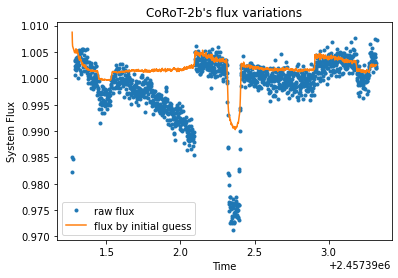

In [16]:
# Your code goes here

theta0_init=[0.40,0.26,0.1,1e-3,0.4,0,0.1,0.1,1,0.01,0.01,0.01,1e-3]
flux_init = flux_theta0(theta0_init,time,x,y,star,planet)
plt.plot(time, flux, '.', label='raw flux')
plt.plot(time, flux_init, label='flux by initial guess')
plt.title('CoRoT-2b\'s flux variations')
plt.xlabel("Time")
plt.ylabel("System Flux")
plt.legend(loc='best')
plt.show()

In [17]:
num_iter = 2000
ndim = 13 # number of parameters
nwalkers = 50
initial_pos = theta0_init + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(time,x,y,star,planet))
state = sampler.run_mcmc(initial_pos, num_iter, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, num_iter, progress=True)

<ipython-input-15-22998b7a9cdb>:16: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(prob_array))
  0%|          | 0/2000 [00:00<?, ?it/s]/Users/zja/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [01:55<00:00, 17.31it/s]


### Question 4f)

Now it's time to examine your results.

1. Plot ```sampler.lnprobability.T``` to see how your log-likelihood evolved over the MCMC run. It should look like a bunch of squiggly lines with no steep slope on the left side of the plot. If there is a steep slope, your MCMC hasn't finished burning in; re-run your two MCMCs using a larger number of steps for the first one to ensure you have burned in the model.

2. Print your fitted parameters from the chain (use the median value) and their associated $68\%$ credibility regions. Make sure to also print the name of each parameter beside the value and uncertainty so it is clear what values belong to what parameters. The `np.percentile` function may be helpful here.

3. Plot your fitted model over top of your raw data, and plot your raw data with the errorbars you found during your fitting.

4. Plot your fitted model divided by your fitted sensitivity model (aka just the astrophysical signal) over top of your raw data divided by your fitted sensitivity model. Now you should clearly be able to see the transit, eclipses, and phase variations.

5. (Optional) Just because it's always fun to look at, feel free to plot a triangle/corner plot of your MCMC results!

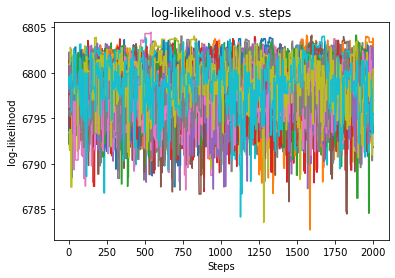

In [18]:
# Your code goes here

plt.plot(np.linspace(0,2000,2000), sampler.lnprobability.T)
plt.title('log-likelihood v.s. steps')
plt.xlabel("Steps")
plt.ylabel("log-likelihood")
plt.show()

In [19]:
fitted_theta0 = np.median(sampler.flatchain, axis=0)
fitted_theta0_68cre = np.array([np.percentile(sampler.flatchain, 32,axis=0), np.percentile(sampler.flatchain, 68,axis=0)]).T
print(fitted_theta0)
print(fitted_theta0_68cre)
print("[star[1], star[2], planet.r, planet.L, planet[1,0], planet[1,1], a, b, c, d, e, f, sigma]")

[-6.90886449e-01  2.47273594e+00  1.44943134e-01  2.85469908e-03
  4.88575221e-01 -2.82373101e-01 -3.40939475e-02 -5.00959916e-02
  9.98915282e-01 -2.49194379e-01 -3.35949021e-03  2.98296838e-02
  1.63851659e-03]
[[-7.93517338e-01 -5.61424235e-01]
 [ 2.26201164e+00  2.63815769e+00]
 [ 1.44225316e-01  1.45466549e-01]
 [ 2.77137882e-03  2.92636404e-03]
 [ 4.76219665e-01  4.97744493e-01]
 [-2.97257957e-01 -2.61107677e-01]
 [-5.13889524e-02 -1.12457773e-02]
 [-5.93830906e-02 -3.84954093e-02]
 [ 9.98838497e-01  9.98990271e-01]
 [-2.74500211e-01 -2.19631501e-01]
 [-4.59006350e-03 -1.96245686e-03]
 [ 2.89484637e-02  3.05108919e-02]
 [ 1.61876584e-03  1.65610676e-03]]
[star[1], star[2], planet.r, planet.L, planet[1,0], planet[1,1], a, b, c, d, e, f, sigma]


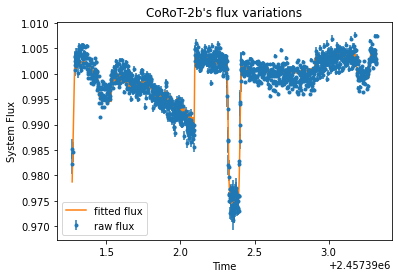

In [20]:
flux_fitted = flux_theta0(fitted_theta0,time,x,y,star,planet)
yerr = (flux_theta0(fitted_theta0_68cre[:,0].T,time,x,y,star,planet)-flux_theta0(fitted_theta0_68cre[:,1].T,time,x,y,star,planet))/2
plt.errorbar(time, flux, yerr=yerr,fmt='.',label='raw flux')
plt.plot(time, flux_fitted, label='fitted flux')
plt.title('CoRoT-2b\'s flux variations')
plt.xlabel("Time")
plt.ylabel("System Flux")
plt.legend(loc='best')
plt.show()

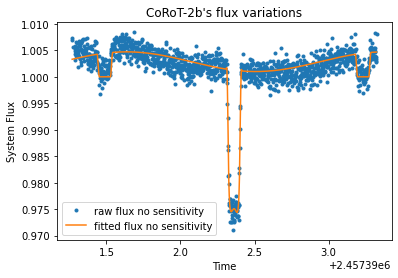

In [21]:
flux_fitted = flux_theta0(fitted_theta0,time,x,y,star,planet)
s_model = sensitivity_model(x, y, fitted_theta0[6], fitted_theta0[7], fitted_theta0[8], fitted_theta0[9], fitted_theta0[10], fitted_theta0[11])
flux_fitted_noS = flux_theta0(fitted_theta0,time,x,y,star,planet) / s_model
plt.plot(time, flux / s_model, '.', label='raw flux no sensitivity')
plt.plot(time, flux_fitted_noS, label='fitted flux no sensitivity')
plt.title('CoRoT-2b\'s flux variations')
plt.xlabel("Time")
plt.ylabel("System Flux")
plt.legend(loc='best')
plt.show()

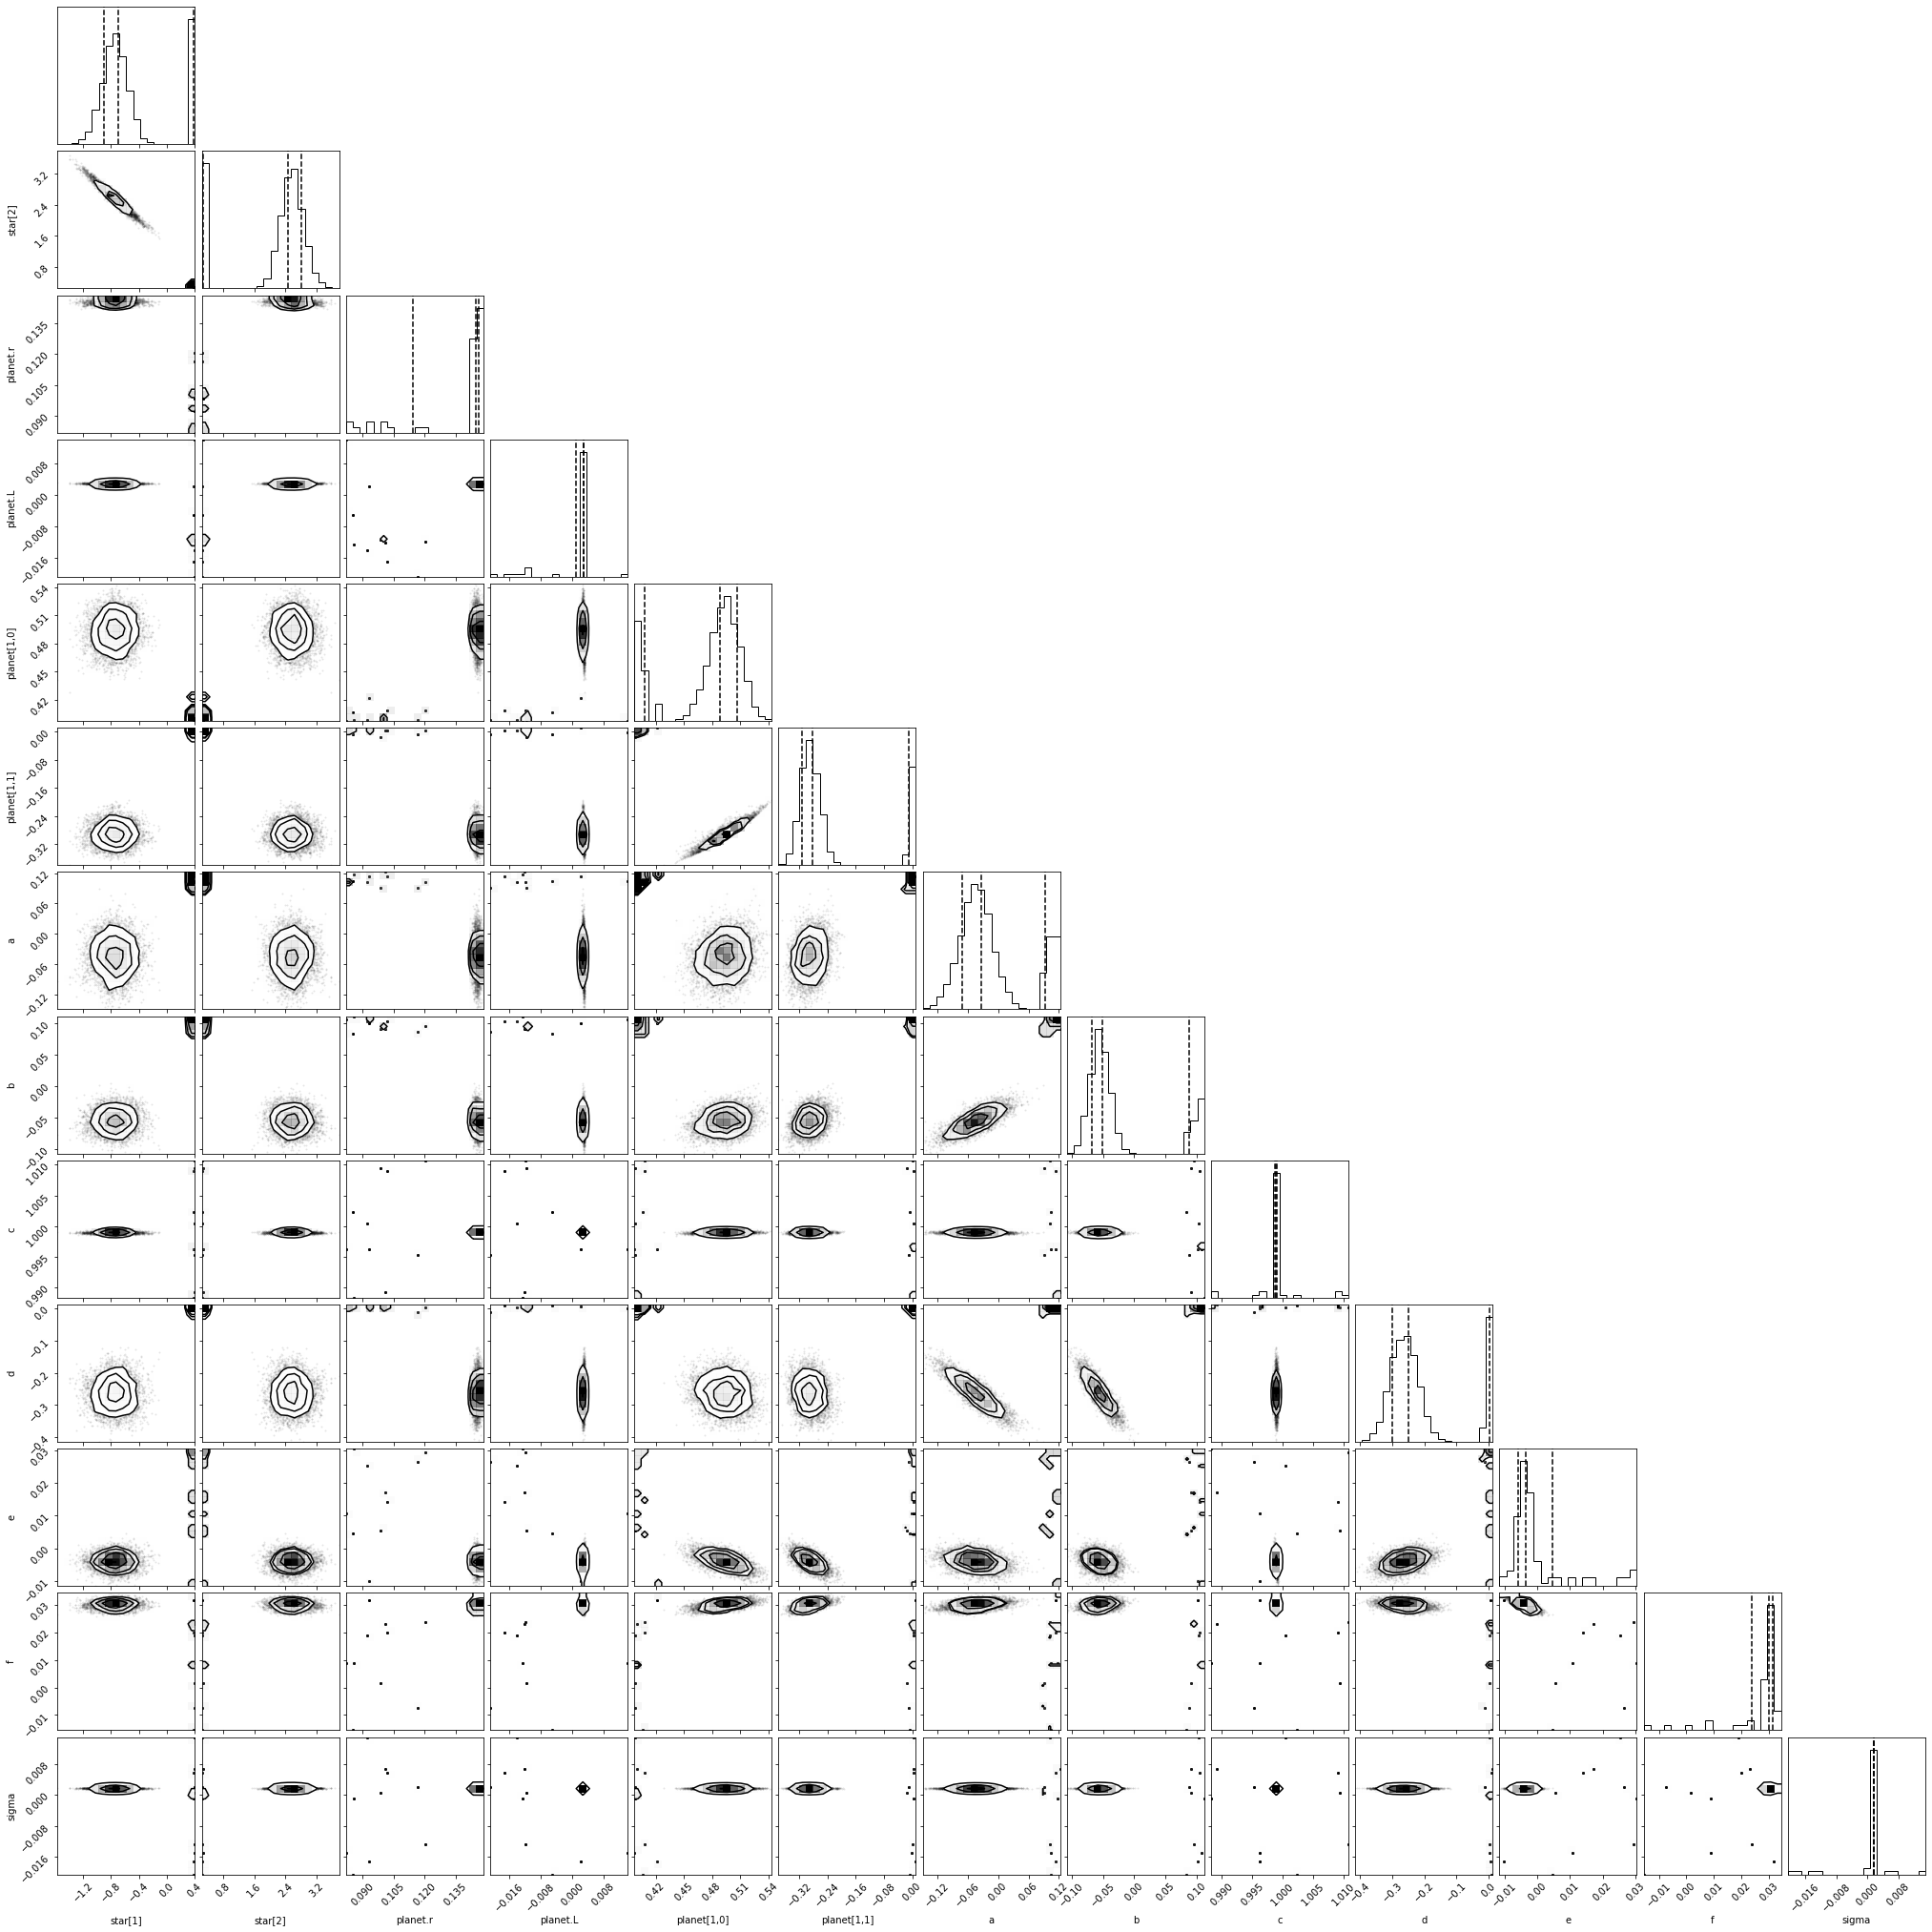

In [22]:
import warnings
warnings.filterwarnings('ignore')

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ['star[1]', 'star[2]', 'planet.r', 'planet.L', 'planet[1,0]', 'planet[1,1]', 'a', 'b', 'c', 'd', 'e', 'f', 'sigma']
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84])

### Question 4g)

Compute the offset in degrees of the peak in the phasecurve from the phase of eclipse using 

```offset = np.arctan2(planet[1,1], planet[1,0])*180/np.pi```.

Positive offsets mean the phasecurve peaks before eclipse. You can also check that your answer is visually consistent with the light curve from the previous question.

Using this knowledge, what direction are the winds on your planet blowing (east or west)? It may help to sketch out some pictures and to remember that winds help to transfer energy (e.g., if you have a wind blowing from a hot region to a cold region, it'll heat up the cold region).

In [23]:
# Your code goes here

offset = np.arctan2(planet[1,1], planet[1,0])*180/np.pi
offset

-30.025857315960348

The degree is negative, which means that the phasecurve peaks after the eclipse. This is visually consistent with the light curve from the previous question.

The direction that the winds on the planet are blowing should be west.

### Question 4h)

Let's now compute the dayside and nightside temperatures of this planet. Earlier we took parameters such as `planet.L` (among others), assumed planet and star temperatures, and computed the expected brightness based on the Planck function. Now we have some actual parameters from observations, so we can invert the Planck function to figure out what the temperatures are.

Take your best-fit values from above and plug it into the provided function below.

In [24]:
def inversePlanck(fp_fstar, rp_rs, Tstar):
    """Invert the Planck function to find the apparent temperature of observed hemisphere.
    
    Args:
        fp_fstar (float): The planet-to-star flux ratio, found using planet.flux(𝜓)*planet.L,
            where 𝜓=0 for the dayside and 𝜓=180 for the nightside
        rp_rs (float): The fitted value of planet.r
        Tstar (float): The stellar effective temperature found at exoplanet.eu
        
    Returns:
        float: The apparent temperature of observed hemisphere in Kelvin.
    
    """
    
    wav = 4.5e-6 # m
    return const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*Tstar))-1)/(fp_fstar/rp_rs**2)))**-1

In [25]:
# Your code goes here

dayside_T = inversePlanck(planet.flux(0)*planet.L, planet.r, 5575.0)
nightside_T = inversePlanck(planet.flux(180)*planet.L, planet.r, 5575.0)
print("The dayside temperature is", dayside_T)
print("The nightside temperature is", nightside_T)

The dayside temperature is 2082.181941112701
The nightside temperature is 1209.0074501005386


### Question 4i)

Of course, we know that anything we measure comes with error bars. In particular, the parameters that you put into the `inversePlanck` function like `planet.L` and `planet.r` have uncertainties associated with them. We need to translate this uncertainty into an uncertainty on our temperature measurements.

Up until now, you've probably done stuff like "propagation of errors" to figure out how to propagate errors through some formula. However, this approach is limited because 1) it usually assumes that the uncertainties in the input numbers are completely uncorrelated, 2) it only works if the errors are small, and 3) the formula is fairly simple.

What we can do instead is to do a Monte Carlo simulation (not to be confused with Markov Chain Monte Carlos). To do this, we go back to the fact that we have a set of randomly drawn samples for `planet.L` and `planet.r` from our MCMC chain. We now step through the chain, and for each step of the chain we take the `planet.L` and `planet.r` values and compute the temperatures. By doing so we accumulate a whole series of temperature values. Plotting a histogram of the final temperatures then gives you the probability distribution of temperatures.

Make histograms of the dayside and nightside temperatures. For each one, estimate the median temperature as well as the $68\%$ and $95\%$ credibility regions.

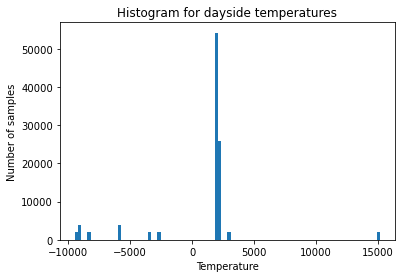

The median for dayside temperature is 2080.867683704782
The 68% credibility regions for dayside temperature is [2047.96705623 2109.70377041]
The 95% credibility regions for dayside temperature is [-8948.38775503  2198.90372076]


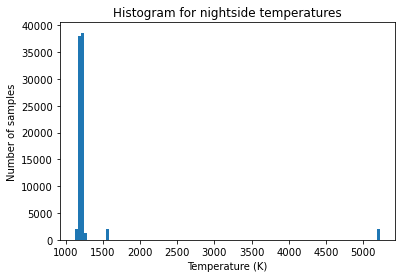

The median for nightside temperature is 1213.7139963618406
The 68% credibility regions for nightside temperature is [1203.72611671 1223.28539393]
The 95% credibility regions for nightside temperature is [1178.69100114 1266.0119688 ]


In [26]:
r_L_chain = sampler.flatchain[:,2:4].T
dayside_T_dist = inversePlanck(planet.flux(0)*r_L_chain[1], r_L_chain[0], 5575.0)
dayside_T_dist = dayside_T_dist[np.logical_not(np.isnan(dayside_T_dist))]
nightside_T_dist = inversePlanck(planet.flux(180)*r_L_chain[1], r_L_chain[0], 5575.0)
nightside_T_dist = nightside_T_dist[np.logical_not(np.isnan(nightside_T_dist))]

plt.hist(dayside_T_dist,100)
plt.title('Histogram for dayside temperatures')
plt.xlabel("Temperature")
plt.ylabel("Number of samples")
plt.show()
print("The median for dayside temperature is", np.median(dayside_T_dist, axis=0))
dayside_68cre = np.array([np.percentile(dayside_T_dist, 32,axis=0), np.percentile(dayside_T_dist, 68,axis=0)]).T
print("The 68% credibility regions for dayside temperature is", dayside_68cre)
dayside_95cre = np.array([np.percentile(dayside_T_dist, 5,axis=0), np.percentile(dayside_T_dist, 95,axis=0)]).T
print("The 95% credibility regions for dayside temperature is", dayside_95cre)

plt.hist(nightside_T_dist,100)
plt.title('Histogram for nightside temperatures')
plt.xlabel("Temperature (K)")
plt.ylabel("Number of samples")
plt.show()
print("The median for nightside temperature is", np.median(nightside_T_dist, axis=0))
nightside_68cre = np.array([np.percentile(nightside_T_dist, 32,axis=0), np.percentile(nightside_T_dist, 68,axis=0)]).T
print("The 68% credibility regions for nightside temperature is", nightside_68cre)
nightside_95cre = np.array([np.percentile(nightside_T_dist, 5,axis=0), np.percentile(nightside_T_dist, 95,axis=0)]).T
print("The 95% credibility regions for nightside temperature is", nightside_95cre)

In practice, Monte Carlo simulations are how one can simulate the error bars on a complicated experiment. Suppose we have some function $f$ that maps the raw data $x$ to the final science result $f(x)$. What I can do is:
* Simulate the true signal that I'm measuring and call it $s$.
* Simulate a whole ensemble of realizations of random noise contributions $n_1, n_2, n_3, \dots$. This can be done if we understand the noise statistics of what I'm measuring. 
* Add each noise realization to the signal to come up with an ensemble of hypothetical measurements $x_1 = s + n_1$, $x_2 = s + n_2$, etc.
* Put each of these $x$ values into $f$ to come up with a series of final measured results.
* Plot a histogram of this series to get the probability distribution for the final science result.

## Don't forget to submit your notebook to GitHub once you are done!